In [1]:
## Notebook env: brian_script_env (R kernel)

In [1]:
library(ggplot2)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(tidyverse)


path2 = '/khayyam/ssobti/projects/heterogeneity_brian/output_data/TCGA_nb_analysis/nb_pause_points/TCGA_breast_q10_q90_original_her2/'


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.4.0     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ dplyr::combine()    masks gridExtra::combine()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [2]:
## load patient metadata
meta = read.csv('/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_bcr_clinical_data_patient.txt', skip = 4, sep='\t')

## classify patients into subtypes
meta_luminal_A = meta %>% filter(ER_STATUS_BY_IHC == 'Positive' | PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Negative')
meta_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Positive')
meta_tnbc = meta %>% filter(ER_STATUS_BY_IHC == 'Negative', PR_STATUS_BY_IHC == 'Negative', IHC_HER2 == 'Negative')
meta_luminal_B_her2 = meta %>% filter(ER_STATUS_BY_IHC == 'Positive', PR_STATUS_BY_IHC == 'Positive', IHC_HER2 == 'Positive')

meta_luminal_A$PATIENT_ID = paste0(str_replace_all(meta_luminal_A$PATIENT_ID, '-', '.'), '.01')
meta_her2$PATIENT_ID = paste0(str_replace_all(meta_her2$PATIENT_ID, '-', '.'), '.01')
meta_tnbc$PATIENT_ID = paste0(str_replace_all(meta_tnbc$PATIENT_ID, '-', '.'), '.01')
meta_luminal_B_her2$PATIENT_ID = paste0(str_replace_all(meta_luminal_B_her2$PATIENT_ID, '-', '.'), '.01')

## Get patient subtype counts
paste('Luminal A patients:', nrow(meta_luminal_A))
paste('HER2+ patients:', nrow(meta_her2))
paste('Triple negative patients:', nrow(meta_tnbc))
paste('Luminal B with HER2+ patients:', nrow(meta_luminal_B_her2))

[1] "Luminal A patients: 445"

[1] "HER2+ patients: 37"

[1] "Triple negative patients: 116"

[1] "Luminal B with HER2+ patients: 100"

[1] FALSE

png 
  2

png 
  2

[1] 73.49141

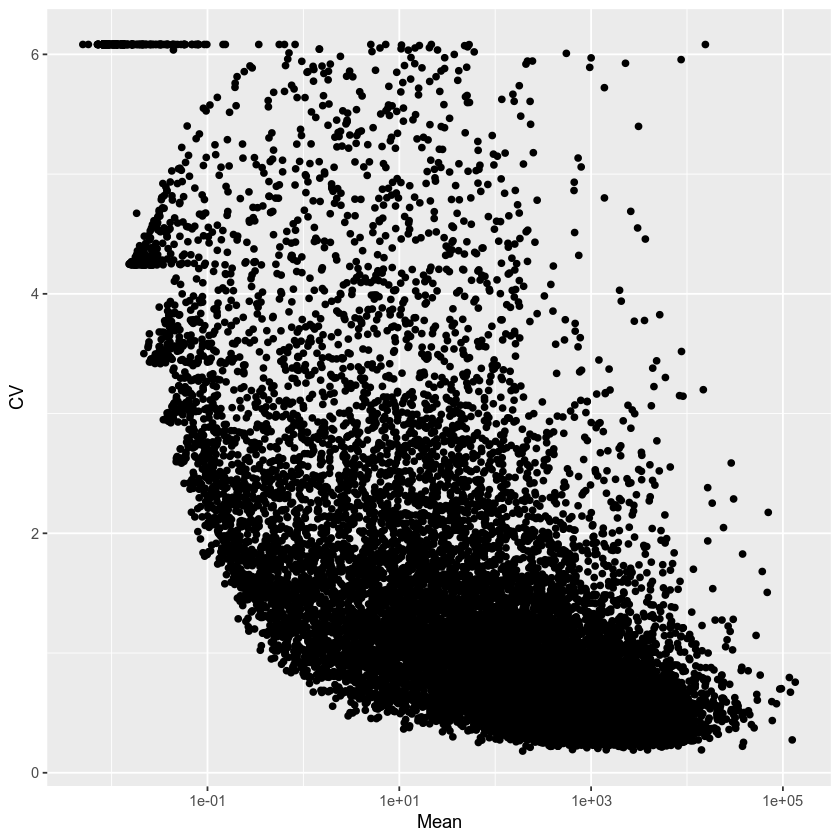

In [3]:
#' ---
#' title: "Analyzing BRCA TCGA data, FPKM data of **medium to high expressing** genes using Brian's script"
#' output: html_notebook
#' ---
#' 
#' This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#' 
#' Let's create a mean vs CV graph for the patients to create a remove low expressing genes with high variability from our analysis
#' 
## ------------------------------------------------------------------------------



## load in data
RNA_Seq_expression_raw_data <- 
read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/brca_tcga/data_RNA_Seq_v2_expression_median.txt", stringsAsFactors = FALSE)

## subset breast cancer patients by type here
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data %>% select(any_of(c('Hugo_Symbol', 'Entrez_Gene_Id', meta_her2$PATIENT_ID))) %>% as.data.frame()

#The 'all' approach to check if all values in a row are 0
check_if_not_zero <- function (vector, number = 0) {
  if (!(all (vector == number))) {
    return (TRUE) #if not zero, then returns TRUE
  }
  else{
    return(FALSE)
  }
}

#See if there are any rows that are FALSE, meaning that are actually all 0
all(as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))) 
zero_genes = as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero)))

##take out genes with no expression in any of the patients
RNA_Seq_expression_raw_data = RNA_Seq_expression_raw_data[as.vector(unlist(apply(RNA_Seq_expression_raw_data[,-1:-2], 1, check_if_not_zero))),]


gene_medians = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, median)

median_df = data.frame(medians = gene_medians)

pdf(paste0(path2, 'gene_expression_pre_filter1.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 500) +
  geom_vline(xintercept = 10, color = 'blue') +
  theme_bw()
dev.off()

pdf(paste0(path2, 'gene_expression_pre_filter2.pdf'), height = 8, width = 8)
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()
dev.off()


pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(gene_medians, 10)

gene_means = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, mean)
gene_CVs = apply(RNA_Seq_expression_raw_data[, -c(1,2)], 1, function(x){sd(x)/mean(x)})


gene_level_df = data.frame(Gene_name = RNA_Seq_expression_raw_data$Hugo_Symbol, Mean = gene_means, CV = gene_CVs)

ggplot(gene_level_df, aes(Mean, CV)) + geom_point() + scale_x_log10(breaks = log_breaks(5))


[1] 914

[1] 2463

[1] 573

[1] TRUE

[1] TRUE

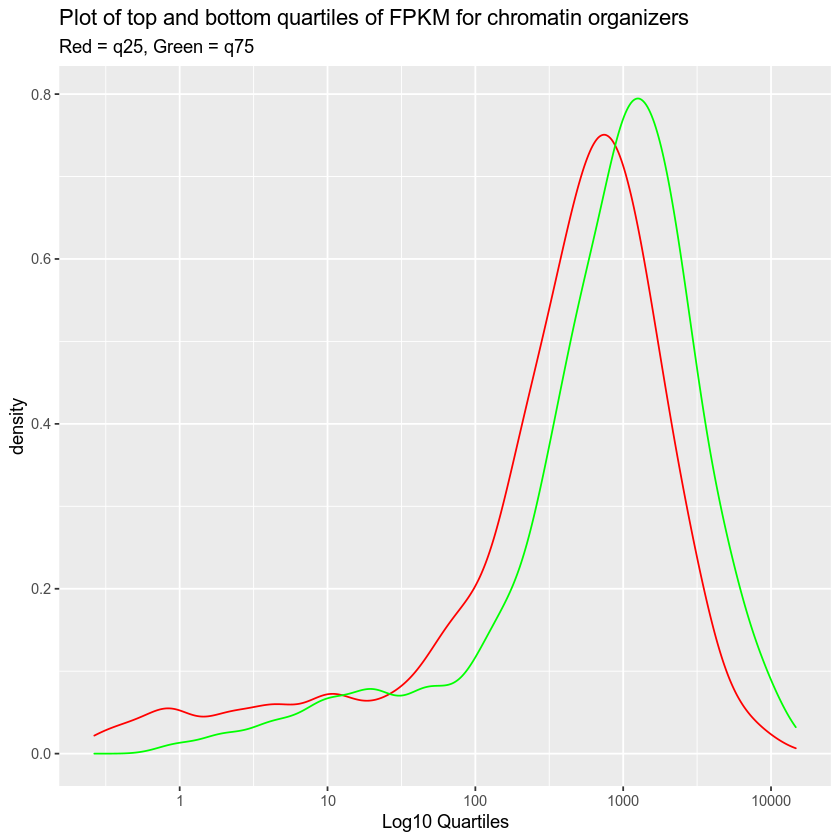

In [4]:
#' Copy and paste Brian's analysis from this point on
## ---- Data loading-------------------------------------------------------------

#Load in chromatin organization modifiers. How this was found: GO term, eukaryota => #mammalia => homo sapiens. Gives a list of gene products; there's non-unique entries #(contributed by different sources, etc)

chromatin_modifiers <- read.delim("/khayyam/ssobti/projects/heterogeneity_brian/uploaded_data/Chromatin_modifiers.txt", header=FALSE, stringsAsFactors=FALSE)

#the first column is the one of interest
colnames(chromatin_modifiers)[1] <- 'Gene Names'

chrom_list_to_sort_against <- unique(chromatin_modifiers$`Gene Names`)

#check lengths of new and original list from chromatin modifiers

length(chrom_list_to_sort_against) 
length(chromatin_modifiers$`Gene Names`)

#logic to extract the chromatin modifier genes specifically from the full RNA Seq list.
#Use the %in% operator to (vector-wise) get the rows specifically. Use this to get
#the quartiles for each gene:

set.seed(42)

chromatin_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% chrom_list_to_sort_against,]

#And these are the 'true' groupings. Let's add a column to denote that here, in front
#of the first two columns using the 'add_column' function from tibble library:

chromatin_genes_RNA_seq <- add_column(chromatin_genes_RNA_seq,
                                      Random = 'N', .after = 2)

length(rownames(chromatin_genes_RNA_seq))

#We'd like to also derive a background distribution for all of these genes. To do so,
#let's append 50 genes that are randomly selected from the dataset, and their #corresponding rows. 

random_genes <- sample(RNA_Seq_expression_raw_data$Hugo_Symbol, 50)
random_genes_RNA_seq <- RNA_Seq_expression_raw_data[RNA_Seq_expression_raw_data$Hugo_Symbol %in% random_genes,]

random_names <- random_genes_RNA_seq$Hugo_Symbol

#Let's also add an equivalently named column here to denote that these are the random genes: 

random_genes_RNA_seq <- add_column(random_genes_RNA_seq, Random = 'Y', .after = 2)

full_genes_RNA_seq <- rbind(chromatin_genes_RNA_seq, random_genes_RNA_seq)

length(rownames(full_genes_RNA_seq)) == 
length(rownames(chromatin_genes_RNA_seq)) + length(rownames(random_genes_RNA_seq)) #TRUE

#creating a threshold with which to create 'hi' vs 'lo' populations of patients; here, I #choose to use top vs bottom quartile. Need to apply quantile across the rows of the #chromatin_genes data frame, excluding the first observation (which is a character string #of the gene name in question)

q25 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.10), na.rm = TRUE)

q75 <- apply(full_genes_RNA_seq[,-1:-3], 1, quantile, probs = c(0.90), na.rm = TRUE)


full_genes_RNA_seq <- add_column(full_genes_RNA_seq, q25 = q25, q75 = q75, .after = 3)

all (full_genes_RNA_seq$q25 <= full_genes_RNA_seq$q75) #true

#Also remove data where the bottom quartile is 0 FPKM. This doesn't seem like it would
#provide any meaningful data to a CV comparison.

full_genes_RNA_seq <- 
full_genes_RNA_seq[!(full_genes_RNA_seq$q25 == 0),]

#Viewing the data and indices

ggplot(full_genes_RNA_seq) + geom_density(aes (x = q25), color = 'red') +
geom_density (aes (x = q75), color = 'green') + 
labs (title = 'Plot of top and bottom quartiles of FPKM for chromatin organizers', 
      subtitle = 'Red = q25, Green = q75',
      x = 'Log10 Quartiles') + 
scale_x_log10()

In [5]:
#' ### Getting groupings of the data based on chromatin modifier expression
#' 
#' We've now completed some EDA of the data and cleaning of useless chromatin modifier factors that wouldn't be good for grouping. Now, let's get dataframes corresponding to these groupings in a list format to each unique chromatin modifier, then use these groupings to get subsetted dataframes from the full dataset corresponding to bottom/top expressers of each chromatin modifier.
#' 
## ---- Getting lo/hi groupings--------------------------------------------------

#Now I want lo and hi expressers (below q25, above q75) for each gene. Way to approach #this: create different groupings, based on hi/lo threshold. To first get the groupings #and return #them in a list: define a function that returns up to three entries in list #format. These are: Gene name, all names below the bottom quantile, and all names above #the top quantile.

groupings_returner <- function (gene, chromatin_data, gene_col = 1, random = 3, 
                                q25_col = 4, q75_col = 5) {
  #the q25_col, q75_col are last two columns in the data frame
  q25 = chromatin_data[chromatin_data[,gene_col]==gene, q25_col] 
  q75 = chromatin_data[chromatin_data[,gene_col]==gene, q75_col]
  rand_designation = chromatin_data[chromatin_data[,gene_col]==gene, random] 
  #get the q25, q75 'indices'
  row = chromatin_data[chromatin_data[,gene_col]==gene, c(-1:-2, -random, 
                                                          -q25_col, -q75_col)]
  #eliminate gene ID, the q25 and q75 columns; isolate a single row
  col = data.frame(t(row)) 
  #get into column format for easy use of row subsetting techniques
  colnames(col) = 'expression_levels'
  list_below_25 = rownames(col[col$expression_levels <= q25,, drop= FALSE]) 
  #to keep row names
  list_above_75 = rownames(col[col$expression_levels >= q75,, drop= FALSE])
  return (list(gene, rand_designation, list_below_25, list_above_75)) 
  #list of 3 entries. First = gene, second = bottom quartile, third = top quartile
}

#let's test that this function works as intended: make a 'test' vector that corresponds 
#to the ACTB gene, then compare this to the corresponding list in the full list.
#Note that the 1103 and 1104 columns correspond to the q25, q75 columns correspondingly.

test <- groupings_returner('HDAC2', full_genes_RNA_seq)

str(test) #should look like a 4 item list

#Some warnings will occur: this is because I sampled 50 randomly from the full dataset.
#Some overlapped with the list of chromatin modifiers list. This seems reasonable to 
#keep though.

groupings <- lapply(full_genes_RNA_seq$Hugo_Symbol, groupings_returner,                                       full_genes_RNA_seq)
str(groupings)

groupings[[2]][2] %in% test[3] #false

groupings[[1]][2] %in% test[2] #TRUE

#should have list of length equal to the chromatin gene list, with two or three entries #in each entry of the list

length(groupings) == length(full_genes_RNA_seq$Hugo_Symbol) 

#Now, using this list of groupings, I should then create dataframes corresponding to each
#groupings list, i.e. for below bottom quantile and above top quantile. This function #should take in a 'key' (each LIST entry within the groupings list) and return either #nothing, or two dataframes.

dataframe_returner <- function (key, full_data, additional_col_vectors = c(),
                                key_gene_entry = 1, key_random_entry = 2, 
                                key_25_entry = 3, key_75_entry = 4) {
    #additional_col_vectors fetches columns by name
  
    #Idea is to aggr. the columns that correspond to the 'correct' patients for each
    #quartile grouping
    q25_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_25_entry]])]
    #key_2/75_entry is a numeric index
    q75_dataframe = full_data[, colnames(full_data) %in% c(additional_col_vectors,
                                                           key[[key_75_entry]])]
    return (list(key[[key_gene_entry]], key[[key_random_entry]],
                 q25_dataframe, q75_dataframe))
}

#As a test: try this with the first gene entry from the above groupings data structure. #Expect: a three-entry list, with the first entry being the gene name, the second and #third being the corresponding data frames. Should have a dataframe with gene IDs, #followed by expression levels.

#use names in this vector to fetch columns corresponding to these two names
gene_vec <- c('Hugo_Symbol', 'Entrez_Gene_Id') 

#check that this list looks correct for a random gene, ACTL6A, index 1)
str(dataframe_returner(groupings[[1]], RNA_Seq_expression_raw_data, gene_vec)) 

#Code to actually get the grouped data
grouped_dataframes_list <- lapply(groupings, dataframe_returner, 
                                  RNA_Seq_expression_raw_data, gene_vec)

#' 
#' ### Appending CVs, CV ratios, to the grouped dataframe object
#' 
#' Let's now calculate CVs and the corresponding CV ratios for each gene between the bottom 
#' and top quartile groups. We will append these to the current grouped dataframes list object made in the previous code chunk. These will be used to determine whether a gene 
#' went up or down in its CV between lower and higher expression of the chromatin modifier in question.
#' 
## ---- Appending CVs------------------------------------------------------------
#First define a coefficient of variation function and apply across each row of the #dataframes in the grouped list:

coeff_variation <- function (vector) {
  return (sd(vector)/abs(mean(vector)))
}

#Calculate coefficient of variation for the entire grouped dataframes list.
#First define a helper function that takes in a list, and applies the given 
#function to the specified entries of the list (here, would like these entries to be the
#second and third entries). It then adds a new column corresponding to the values it 
#calculated. 

#omit the two first cols from being within the coeff_var calc, as they correspond to the #name/Gene ID for the gene in question

indices_omit <- -1:-2 

#This function operates at the level of a single dataframe. It takes in a dataframe and 
#returns a modified dataframe that has CV appended to the dataframe as a column. 

col_adjuster <- function (entry, omitted_indices = indices_omit, row_or_col = 1,
                          column_to_add_after = 2, col_name = 'CV',
                          f = coeff_variation, ...) {
  if (is.data.frame(entry)) {
    #has this is.data.frame entry so I can just simply apply this function across 
    #all of the list entries in the df_list that contain either df's or strings
      "... refers to the arguments of 'f'"
      col_result <- apply(entry[, omitted_indices], row_or_col, f, ...)
      #print(CV)
      entry <- add_column (entry, name = col_result, .after = column_to_add_after)
      colnames(entry)[colnames (entry) == 'name'] <- col_name 
      #adds the CV col (result of applying the function f) to original entry dataframe,
      #reassigning the name to match the name of the (statistic) calculated, e.g. CV, etc
  return (entry)
 #return the modified entry
  } else {
    return (entry)
  }
}

#Double apply call: nested lapply call works at the single list of dataframe level, 
#and the outer lapply call works to apply this across the entire grouped_dataframes_list
#object

grouped_dataframes_list_with_CV <- pblapply(grouped_dataframes_list, function (list) {
  lapply (list, col_adjuster) })

#Check that manually calculating CV gives the same result as this above call:

test_CV <- coeff_variation(as.numeric(grouped_dataframes_list[[2]][[3]][2,-1:-2]))

CV_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][2,]$CV

CV_not_to_match <- grouped_dataframes_list_with_CV[[2]][[3]][50,]$CV

test_CV == CV_to_match #TRUE

test_CV == CV_not_to_match #FALSE
                                
#Now, take the ratios of the CV values. After doing this, then will have e.g. ~20440 #ratios. This function below works at the level of a 3-entry list, with one specified #entry in the list being a dataframe corresponding to bottom quantile, and vice versa for #top quantile.

CV_divider <- function (list, CV_index = 3, q25_entry = 3, q75_entry = 4) {
  #Calculate the CV ratio between q25 and q75 by dividing the two respective cols
  CV_ratio <- list[[q25_entry]][, CV_index]/list[[q75_entry]][, CV_index]
  
  list[[q25_entry]] <- add_column(list[[q25_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  #adds a CV_ratio column to the bottom quantile dataframe in the list
  list[[q75_entry]] <- add_column(list[[q75_entry]], CV_ratio = CV_ratio, 
                                  .after = 3)
  return (list)
}

#See if this function works for just one entry in the full dataframe list (i.e. a 3-
#entry list)

test_CV_ratio <- CV_divider(grouped_dataframes_list_with_CV[[2]])

test_CV_ratio[[3]]$CV_ratio #should exist

grouped_dataframes_list_with_CV_ratio <- lapply(grouped_dataframes_list_with_CV, 
                                                CV_divider)

#Remove rows with NaN: define a function that removes all rows that are NaN for the 
#specified CV_ratio column (here, the 4th index). This meant that all of the rows
#were 0 for either the q25 grouping or q75 grouping, not unexpected (many genes 
#had high levels of 0's in the full dataset).

#!!Huge memory sink!! NEED TO FIX THIS. MEMORY VIRTUAL EXHAUSTED

#options (future.globals.maxSize = 4000 * 1024^5)

NaN_omitter <- function (entry, CV_ratio_col = 4) {
  if (is.data.frame(entry)) {
    return (entry[is.finite (entry[, CV_ratio_col]) ,])
  } else {
    return (entry)
  }
}

lapply_wrapper <- function (df_list, f) {
  return (lapply(df_list, f))
}

grouped_dataframes_list_with_CV_ratio_cleaned <- pblapply(grouped_dataframes_list_with_CV_ratio, lapply_wrapper, NaN_omitter)

#check that names match:
names_list <- lapply(grouped_dataframes_list, function (list) list[[1]])

names_CV_ratio <- lapply(grouped_dataframes_list_with_CV_ratio, function (list) 
  list[[1]])

names_CV_clean <- lapply(grouped_dataframes_list_with_CV_ratio_cleaned, function (list) 
  list[[1]])

identical(names_list, names_CV_ratio)

identical(names_list, names_CV_clean)

save(grouped_dataframes_list_with_CV_ratio_cleaned, file = paste0(path2, 'gped_clean_df_CV_ratio_q10_q90.RData'))

List of 4
 $ : chr "HDAC2"
 $ : chr "N"
 $ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALJ.01" "TCGA.5T.A9QA.01" ...
 $ : chr [1:275] "TCGA.A1.A0SB.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" ...
List of 560
 $ :List of 4
  ..$ : chr "ACTL6A"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.5L.AAT1.01" "TCGA.A1.A0SD.01" "TCGA.A1.A0SG.01" "TCGA.A2.A04W.01" ...
  ..$ : chr [1:275] "TCGA.5T.A9QA.01" "TCGA.A1.A0SI.01" "TCGA.A1.A0SJ.01" "TCGA.A1.A0SK.01" ...
 $ :List of 4
  ..$ : chr "ACTR5"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AALJ.01" "TCGA.A1.A0SB.01" "TCGA.A1.A0SE.01" "TCGA.A1.A0SH.01" ...
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.5L.AAT1.01" "TCGA.5T.A9QA.01" ...
 $ :List of 4
  ..$ : chr "ACTR6"
  ..$ : chr "N"
  ..$ : chr [1:275] "TCGA.3C.AAAU.01" "TCGA.3C.AALI.01" "TCGA.3C.AALK.01" "TCGA.A1.A0SF.01" ...
  ..$ : chr [1:275] "TCGA.A1.A0SK.01" "TCGA.A1.A0SO.01" "TCGA.A2.A04T.01" "TCGA.A2.A0CM.01" ...
 $ :List of 4
  ..$ : chr "ACTR8"
 

[1] FALSE

[1] TRUE

[1] TRUE

List of 4
 $ : chr "ACTL6A"
 $ : chr "N"
 $ :'data.frame':	20251 obs. of  277 variables:
  ..$ Hugo_Symbol    : chr [1:20251] "LOC100130426" "UBE2Q2P3" "UBE2Q2P3" "LOC149767" ...
  ..$ Entrez_Gene_Id : int [1:20251] 100130426 100133144 100134869 10357 10431 155060 26823 280660 317712 340602 ...
  ..$ TCGA.5L.AAT1.01: num [1:20251] 0 0 10.6 116 1108.4 ...
  ..$ TCGA.A1.A0SD.01: num [1:20251] 0 9.52 11.32 60.26 977.92 ...
  ..$ TCGA.A1.A0SG.01: num [1:20251] 0 6.06 4.38 68.58 1072.81 ...
  ..$ TCGA.A2.A04W.01: num [1:20251] 0 1.31 4.64 101.33 1759.83 ...
  ..$ TCGA.A2.A04X.01: num [1:20251] 0 1.48 2.85 70.51 1451.2 ...
  ..$ TCGA.A2.A0CK.01: num [1:20251] 0 0.998 2.638 113.665 795.556 ...
  ..$ TCGA.A2.A0CL.01: num [1:20251] 0 10.77 7.76 91.26 738.32 ...
  ..$ TCGA.A2.A0CO.01: num [1:20251] 0 9.86 6.43 97.52 572.74 ...
  ..$ TCGA.A2.A0CP.01: num [1:20251] 0 10.23 4.51 96.51 1263.4 ...
  ..$ TCGA.A2.A0CQ.01: num [1:20251] 0 7.47 5.75 86.6 1406.34 ...
  ..$ TCGA.A2.A0CR.01: num [1:20251] 0

[1] TRUE

[1] FALSE

[1]  1.02410255  0.90368186  1.05170307  0.92982322  0.97503771  0.96496721
    [7]  0.87765489  0.79201798         NaN  0.40808203  0.92418063  1.01058422
   [13]  1.63817605  1.04387018         NaN         NaN  1.57032213  1.17976221
   [19]  0.83404989  0.70381333  0.60440167  1.00260821         NaN  0.70851314
   [25]  1.63820149  2.69668113  0.71282094  0.75965029  2.28768288  3.57246060
   [31]  1.39956772  0.96830789  1.59634539  1.16838328  1.08393751  0.96146119
   [37]  0.83081283  0.90177706  1.68842131  0.63604146  0.82597862  0.63690488
   [43]  0.89178215  4.92758393  0.72988116  0.84860825  0.94558615  0.83447468
   [49]  0.38455014  1.10017834  0.65636351  1.08703453  0.94844729  1.21101926
   [55]  0.85331850  0.76830727  1.02870191  0.87039916  1.17663253  0.93133440
   [61]  1.05140483  1.32644302  0.90873153  1.05965117  1.03303941  1.19647282
   [67]  0.83467957  1.08147135  1.05865447  0.94029523  0.93770480  1.17314814
   [73]  0.85781841  1.10026783  1.12686122  1.45022273  0.96156672  0.90607744
   [79]  0.90765984  0.90929501  1.07656140  1.05796234  0.80372874  0.70290287
   [85]  1.46054362  1.11244291  3.38402589  0.74079758  0.99445372  0.96639569
   [91]  1.13430960  1.16032807  1.05676996  0.85311689  0.61362506  0.77956678
   [97]  1.08669170  0.98663272  0.82067170  0.82053684  1.25403928  0.84418308
  [103]  0.90841695  1.05082864  0.40217073  2.29387109  2.99077143  0.94134371
  [109]  0.92237106  1.10960358  1.05047964  1.46683858  0.96979963  0.91570829
  [115]  0.71670063  0.77988127  0.96703375  0.69853772  1.50095837  0.90459758
  [121]  0.87506295  0.91906290  0.78661963  1.11598187  0.95821564  0.93973420
  [127]  0.80782101  0.84428774  0.94715162  0.82605767  1.22108960  0.85400990
  [133]  0.92708099  1.22542074  3.34198614  1.09438019  1.10229517  0.72661347
  [139]  0.87042017  0.75662654  0.91763558  0.70032485  1.11595262  0.75055884
  [145]  0.84452360  1.01741965  0.93478450  0.63769026  0.81122999  0.83007967
  [151]  0.93068868  0.70602560  1.03633458  0.98573536  0.82848881  0.95356774
  [157]  1.02437837  0.93630181  0.93406477  0.82455453  0.88385955  0.97701037
  [163]  1.26292015  1.57553955  1.30578026  0.78189712  0.55825835  1.15952614
  [169]  1.09310969  1.10071906  1.07339855  0.98796063  0.49314377  1.28583183
  [175]  1.21215358  1.15226487  0.38904125  1.01183503  0.80975769  0.76835268
  [181]  0.94058997  1.16055380  1.01353084  1.29419577  1.88462501  1.06086975
  [187]  0.83708346  0.84996755  0.94108330  0.37622747  1.16438334  1.00160537
  [193]  1.03506599  0.75278362  0.88750090  0.82966024  1.20141332  0.84750767
  [199]  0.94309020  0.27855284  0.88810151  0.74817830  0.63363373  1.56739687
  [205]  1.00215257  0.93858642  0.93735302  1.16310140  0.54473515  0.93591106
  [211]  0.90163821  0.76755289  0.88267882  0.91846127  1.28138991  0.74531082
  [217]  1.63899755  0.42180299  0.79149442  2.41266010  1.04985314  0.97101515
  [223]  1.00209795  0.96901928  0.87584616  0.98383519  3.06197472  1.08924893
  [229]  0.70097754  1.11262980  3.84599508  0.90221481  0.73432307  0.96070112
  [235]  0.55318570  0.91187572  1.30081777  1.23749303  1.28808549  0.98352959
  [241]  3.42784891  1.47518923  0.92591366  0.90681819  0.89271301  1.05206408
  [247]  0.91839455  1.30400326  1.11577194  1.00482612  0.26602877  1.00612936
  [253]  0.91125825  1.44186645  0.98746907  1.01086404  0.80262316  0.92448521
  [259]  0.97214285  0.86916070  0.91279316  0.68838866  2.54363092  1.13593440
  [265]  0.97196615  0.92214031  0.22396466  0.91873737  0.76852364  1.59468220
  [271]  1.19472385  1.01553654  0.82345848  0.67412180  0.69540259  0.86281558
  [277]  0.81890078  0.78491287  0.86354369  0.82821684  1.24412812  1.12600830
  [283]  1.35425510  0.84005087  0.60399371  0.81836539  1.10171960  1.09645434
  [289]  0.86604210  1.18937640  1.22387753  0.62946306  1.11567759  0.86864225
  [295]  0.93085376  0.90274622  0.71493480  1.16241418  1.17175415  1.43030065
  [3

[1] TRUE

[1] TRUE